In [ ]:
import keras
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fake_or_real_news.csv')
df['merged_text'] = df['title'] + '. ' + df['text']
df.loc[df['label'] == 'REAL', 'target'] = 0
df.loc[df['label'] == 'FAKE', 'target'] = 1
df.head()
df_pick = df[['merged_text', 'target']]

1. Load data as train and test data.   
  a. add Title to text and create final text, label ordered pair.  
  b. Split 80-20 into train and test datasets.

In [ ]:
training_data = df_pick.sample(frac=0.8, random_state=25)
testing_data = df_pick.drop(training_data.index)

print(training_data.shape)
print(testing_data.shape)

(5068, 2)
(1267, 2)


In [ ]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(training_data['merged_text'].values, tf.string),
            tf.cast(training_data['target'].values, tf.int32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(testing_data['merged_text'].values, tf.string),
            tf.cast(testing_data['target'].values, tf.int32)
        )
    )
)
BUFFER_SIZE = 10000
BATCH_SIZE = 4
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in training_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Knesset Speaker asks Vatican to join battle against UNESCO\xe2\x80\x99s denial of history. October 26, 2016 Knesset Speaker asks Vatican to join battle against UNESCO\xe2\x80\x99s denial of history \nThe resolution, the Speaker wrote, \xe2\x80\x9cis an assault on history and is deeply offensive to both Christianity and Judaism. The denial of the historicity of the two Jerusalem Temples and the Temple Mount as recounted in both the Old and New Testaments is a terrible indictment of the international community when repeatedly adopted by an important UN body. \n\xe2\x80\x9cThe outrageous repudiation of the millennia-old bond between Judaism and its holiest shrines in Jerusalem is a blatant attempt to rewrite history,\xe2\x80\x9d he added. \xe2\x80\x9cThe annals of both our religions cannot be erased by raised hands and counted votes.\xe2\x80\x9d \nEdelstein said the time has come for the international community to pass a resolution reaffirming Jerusalem as the holy city for the

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(training_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'that', 'is',
       'for', 'on', 'as', 'it', 'with', 'he', 'was', 'are', 'be', 'this'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1, 740,   1, ...,   0,   0,   0],
       [ 19,   1,   1, ...,   1, 115, 155],
       [ 77,   6, 196, ...,   0,   0,   0]])

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00364072]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(training_dataset, epochs=1,
                    validation_data=test_dataset,
                    validation_steps=1)

1267/1267 [==============================] - 1494s 1s/step - loss: 0.5949 - accuracy: 0.6579 - val_loss: 0.1406 - val_accuracy: 1.0000


In [19]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.6176637299358845)

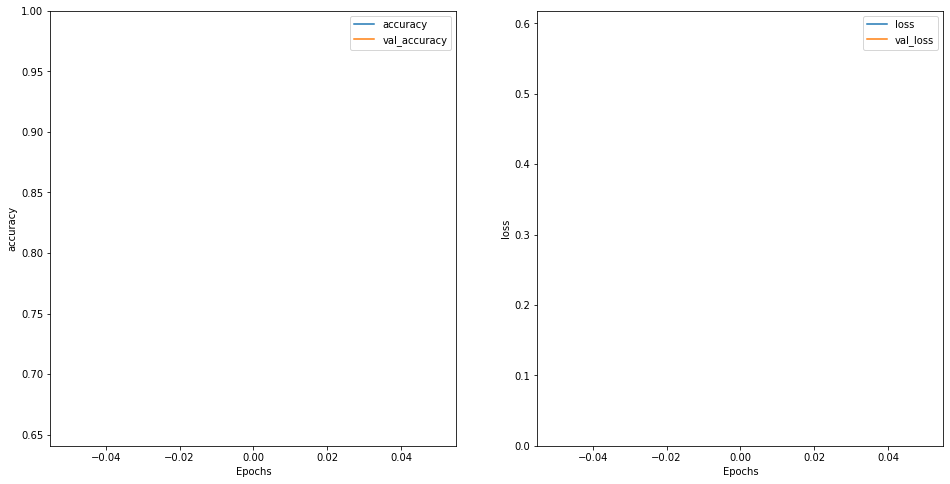

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)